# M17 Modulator

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

Please attribute the work to *Rob Riggs, WX9O, Mobilinkd LLC*.

This notebook contains the lab notes on implementing an M17 baseband
encoder and modulator.  There are a few key components of this, and
more complex implementations, ones that are designed to handle more
than just voice communication, may have many more components.

The hope is that, by publishing these notes, they will serve to help
others implement the M17 over the air (OTA) standard, and that the
implementation will provide a reference point for M17 interoperability.

The goal here is not to provide an overview of what M17 is in any
detail.  The target audience are amater radio operators that know
what M17 is and are interested in how an M17 modulator might be
implemented.

If you would like to learn about the M17 project, please start here:
https://m17project.org/

## References

https://m17-protocol-specification.readthedocs.io/_/downloads/en/latest/pdf/
https://www.qsl.net/kb9mwr/projects/dv/dmr/Roger%20Kane_Understanding%20and%20testing%20of%20DMR%20standard.pdf

## Overview

M17 is a digital transmission mode designed for voice and data.  It is
similar to DMR or D-Star in this respect. This implementation focuses on
the voice component.

 * M17 voice uses Codec2 at either a 3200bps or a 1600bps coding rate.
 * M17 voice uses fixed 384-bit (48 byte) blocks of raw data, streamed back to back.
 * M17 streams data at 25 blocks per second (40ms each), 4800 symbols per second, 9600 bits per second.
 * M17 uses a punctured convolutional FEC (k=5) for data.
 * M17 uses a enhanced Golay(12,24, 8) code for link information.
 * M17 uses a polynomial interleaver.
 * M17 uses an XOR-based bit randomizer (to prevent long runs of 0s or 1s).
 * M17 uses a 4-FSK modulation scheme.
 * M17 uses a 6.25KHz (narrow) channel bandwidth and 12.5KHz channel spacing.
 * M17 provides 3200bps encoded data throughtput.

We will review the basic requirements before going into a simple implementation.
For the details, please review the spec linked above in the [References](#References)
section.

In [1]:
%pylab inline

import scipy
import scipy.signal
import scipy.io.wavfile

import numpy as np
import pygraphviz as pgv
from IPython.display import Image
import numba

def draw(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

Populating the interactive namespace from numpy and matplotlib


## Glossary

This is a glossary of terms used in this document.  It differs slightly from the terminology used in the curent version of the M17 spec as it attempts to reduce ambiguity and favor specificity and a common vocabulary.

 * `encrypt`: the use of ciphers to hide the contents of a message from all but the intended recipient(s).
 * `decrypt`: decode a message encrypted with a cipher.
 * `scramble`: the use of a specific algorithm to obscure the contents of the message.
 * `preamble`: the beginning part of a transmission used to syncronize a receiver with a transmitter.
 * `interleave`: use a reversable algorithm to re-order the bits so that they are no longer correlated in time.  The purpose of interleaving is to ensure that a burst error affects uncorrelated bits.  This improves error correction.
 * `randomize`: the use of a sequence of bits which are XORed with the payload in order to prevent long runs of the same bit (1 or 0).  This is also called *de-correlation* or *frequency whitening*.  The purpose is to increase the frequency of symbol transitions, reducing the low frequency component of the baseband signal.
 * `FEC`: forward error correction; encoding the data in such a way that redundant information is added which can be used to correct errors in the received bit stream.
 * `CRC`: cyclic redundancy check; a checksum of the bits in a complete packet.  A CRC is used to ensure that the packet that was decoded has been received correctly.  In M17, the FEC algorithms used can increase the likelyhood of correcting errors but it cannot tell you that all errors have been corrected.
 * `encode`: the act of converting information from one form into another. Generally we use the term "encode" when modulating a signal, and "decode" when demodulating a signal. 
 * `encoding`: a specific data format. It is a defined way of representing specific data. Almost universally this requires a specifier to indicate what information is being encoded, whether audio data (audio encoding) or call sign (ID encoding).
 * `modulate`: encoding binary data in an analog form.  In general we differentiate between *baseband modulation* which is what this document focuses on and *RF modulation* which involves modulating an RF carrier with a baseband signal.
 * `demodulate`: the inverse of modulation; converting an analog signal back into a digital form.  This is also differentiated between *RF demodulation*, converting a radio signal into baseband modulation, and *baseband demodulation* which is to convert the baseband analog signal back into a digital signal.
 * `decode`: the inverse of encode; the act of converting information from one form into another.  We generally use "decode" when referring to demodulation.  We decode symbols into bits, and encode bits into symbols.
 * `baseband`: the analog data at (or at least near) the frequency of the data being transmitted.
 * `LICH`: link information channel, a side channel separate from the main data payload designed to carry link information data.
 * `superframe`: partial data about the current transmission sent with each data frame in the LICH.  The complete link information (link setup frame) is spread across 5 sequential packets.


## 4-FSK

The bits in a digital message are packaged into 2-bit symbols. These symbols
are encoded into a 4-level baseband signal.  This is filtered using a root-raised
cosine filter. This is the baseband signal which is passed to the RF modulator.

The mapping of 2-bit symbols into 4-FSK symbols is:

|Bits|Symbol|
|----|------|
|  01|+3    |
|  00|+1    |
|  10|-1    |
|  11|-3    |

##  Streaming vs Packet Mode

Audio is transmitted using the streaming mode.  That is what we will focus on
here.  Packet mode has not be well defined in the M17 specification at this
time (Sept 2020).  It is not clear that it is really necessary.

##  Preamble

The preamble is a series of alternating +3/-3 symbols that result in a 40ms
pulse of a 2400Hz sine wave.  The stream starts with a preamble.  It is sent
just once at the start of the stream.

##  Packetization

Voice is digitally encoded and sent in packets or frames.  Each packet is
368 bits in length, and is preceded by a 16-bit sync symbol.  The sync symbol
is used to identify the start of each packet.  This is necessayr to maintain
synchronization between the transmitter and receiver.  It allows late-joiners
to be able to synchronize their decoders with the packet stream.

Note that "late joiners" can refer to anyone, including the primary participants
in a conversation whose links are interrupted by interference or loss of signal.

## Link Setup

The first packet in a stream is responsible for link setup, identifying the
source, the destination and data type.

The link information is repeated piecemeal in the stream so that late joiners
can reproduce the link information in the Link Setup frame.

## Addressing

Addresses are base-40 compressed 48-bit address.

The broadcast address is 0xFFFFFFFFFFFF.

Please see the spec for details on callsign and SSID encoding.

## Codec2

Audio data is encoded at either 1600bps or 3200bps using Codec2.
We will focus here exclusively on 3200bps mode (voice only).

## Data

Data frames follow the Link Setup frame and contain a 48-bit LICH
(link information channel) payload, a 16-bit sequential frame
number (FN), and the data payload.  Each data frame contains 128
bits of raw data.  This provides 3200 bits per second throughput.

## CRC

A 16-bit CRC is appended to the frame.  The frane number and data
feed into the CRC.  The CRC provides a message integrity check to
validate the frame contents.

## Forward Error Correction

Forward error correction (FEC) is data integrity scheme where the data
is encoded in a way which allows errors to be detected and corrected
using redundant information.  There are two FEC schemes used in M17.

The primary scheme is a k=5 convolutional code with different puncture
matrices for link setup and audio data.  The Link Setup frame and the
data portions of the Data frame are encoded using this scheme.

The LICH in each data frame are encoded using a Golay(24,12,8) code.
48 raw bits of LICH data are encoded in 96 FEC bits.

The purpose of encoding the LICH with Golay is to reduce the decoding
complexity, since it is expected that idle stations will monitor a
stream, decoding the LICH to see if there is traffic of interest. 
They will not have to bear the cost of decoding the entire frame using
a trellis decoder.

There are two puncturing matrices, one for the Link Setup frame and one
for the data channel.  This is because the entire 240 bits of the link
setup frame is convolutionally coded whereas only 144 bits of the data
frame are encoded.  Also, the data frame retains more FEC bits than the
link setup frame.

The Golay code provides both error correction and parity information.  It
does not provide the same strong message integrity guarantees that a CRC
provides.

## Interleaving

The 368 bits in each frame are interleaved to spread the bits evenly
across the 368 bit frame.  This provides increased immunity from error
bursts.  Bits corrupted in a burst are unlikely to be correlated when
run through their respective FEC decoders.

## Randomization

The bit stream is further randomized to avoid long runs of the same
symbol.  This is undesireable as it impairs synchronization in the
demodulator and adds a low-frequency component to the baseband signal.
Randomization is done using a pre-defined array of bits which are
XORed with the interleaved bit stream.

# Implementation

We will now go through the implemenation of the encoder/modulator.
To keep things simple, so we are not having to deal with real-time
audio, we will encode a pre-recorded WAV file.

 1. Construct the preamble
    1. Split the bits into symbols
    1. Modulate the symbols
    1. Filter the modulated data
 1. Construct the Link Setup frame
    1. Encode the sender and receiver call signs (MYCALL, TOCALL)
    1. Add the link flags
    1. Compute the CRC
    1. FEC encode the data
    1. Puncture the data
    1. Interleave the bits
    1. Randomize the bits
    1. Prepend the sync word
    1. Split the bits into symbols
    1. Modulate the symbols
    1. Filter the modulated data
 1. Construct LICH segments from the link setup frame
 1. Golay encode the LICH segments
 1. Read the audio data
 1. Encode the audio using Codec2
 1. Split the audio into 128-bit (16 byte) chunks
 1. Send the chunks one at a time
    1. Combine frame number and audio chunk
    1. Compute CRC from FN and chunk
    1. FEC encode the data (FN, chunk, CRC)
    1. Puncture the data
    1. Interleave and randomize the data
    1. Prepend the sync word
    1. Modulate and filter the Data frames

At the very basic level, the digital to analog modulator looks
like this.

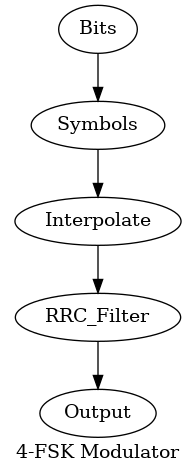

In [2]:
g1 = """digraph top {
   label = "4-FSK Modulator";
   
   Bits -> Symbols -> Interpolate -> RRC_Filter -> Output;
}"""

draw(g1)

And a complete M17 transmission looks like this.

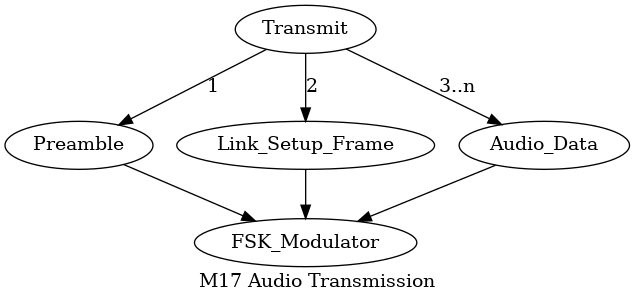

In [3]:
g2 = """digraph top {
   label = "M17 Audio Transmission";
   
   Transmit -> Preamble [label="1"];
   Transmit -> Link_Setup_Frame [label="2"];
   Transmit -> Audio_Data [label="3..n"];
   Preamble -> FSK_Modulator;
   Link_Setup_Frame -> FSK_Modulator;
   Audio_Data -> FSK_Modulator;
}"""

draw(g2)

# Preamble

The preamble is the easiest place to start with the modulator.  It will
allow us to build up the core 4-FSK baseband modulator.

The preamble consists of alternating +3,-3 (01,11) symbols. The specification
defines this as 40ms in duration, which is equivalent to 192 symbols or 384
bits.  This is also equivalent to 48 bytes of 0x77.  We are going to start by
creating a preamble based on bytes.

We will then convert bytes to two-bit values (or dibits) with the values 0
through 3, and then map those values to the 4-FSK symbols [-3, -1, 1, 3].
We will feed in 48 bytes and get back 192 4-FSK symbols.

In [4]:
def to_4fsk(symbol):
    """Convert a pair of bits to a 4-FSK symbol."""
    if symbol == 0: return 1
    elif symbol == 1: return 3
    elif symbol == 2: return -1
    elif symbol == 3: return -3
    else: raise ValueError("not a value 4-FSK symbol")
    
def binary_to_symbols(bits):
    """Return an array of binary symbols (bit pairs) to 4-FSK symbols."""
    return np.array([to_4fsk(x) for x in bits], dtype=np.int8)

def byte_to_symbols(data):
    """Convert byte to big endian symbol stream."""
    result = np.zeros(4, dtype=np.uint8)
    for i in range(4):
        result[i] = (data & 0xC0) >> 6
        data = data << 2
    return result
        
def bytes_to_symbols(data):
    binary_symbols = np.concatenate(np.array([byte_to_symbols(x) for x in data]))
    return binary_to_symbols(binary_symbols)

preamble_bytes = np.array([0x77]*48, dtype=np.uint8)
preamble_symbols = bytes_to_symbols(preamble_bytes)
print(preamble_symbols)

[ 3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3
  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3
  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3
  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3
  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3
  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3
  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3
  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3  3 -3]


## Filtering

We now have 192 4-FSK symbols.  These symbols need to be filtered with
a root raised cosine filter ($\alpha=0.5$).  Let's discuss what we need
from this filter.

We are going to want to output a signed 16-bit, 48kHz signal.  We can feed
such a signal into an sound card or DAC. And we would like to stay in the
integer domain, avoiding floating point if possible.

We need to take our 4800 symbols per second radio and up-convert it by 10x. 
We want our output to be in the range 32767 to -32768.

See also:

 * https://stackoverflow.com/a/28951239/854133
 * https://www.analog.com/media/en/technical-documentation/application-notes/AN-922.pdf
 * https://gist.github.com/philpem/b24bfb98f1fd39e856ea794a3f9f36e6
 * http://commpy.readthedocs.org/en/latest/generated/commpy.filters.rrcosfilter.html

Note that after upgrading scikit-commpy to 0.5.0, RRC is a bit broken.
The filter coefficients are no longer symmetric and requesting an even
number of taps will result in no error, but can result a very bad
filter response.

### Upsampling / Interpolation

We need to increase the sample rate from 4800 symbols per second to
48000 samples per second, a 10x increase.  We can do this one of two
ways.

 1. Insert n-1 0s between each symbol
 1. Replicate the symbol n times

The result after filtering will be the same, with just a different
gain.  We are going to use the second method.

In [5]:
def upsample(input, n, gain = 1):
    """Upsample (interpolate) the input by the 'n'.  This does
    nothing more that duplicate each symbol n times.  It can
    also provide a gain factor."""
    
    return np.concatenate([np.array([x] * n, dtype = input.dtype) for x in input]) * gain

### Filter Coefficients

We are now going to generate the filter coefficients.  These coefficients
are going to be scaled so that we produce a 16-bit values suitable for
audio (WAV format) output.

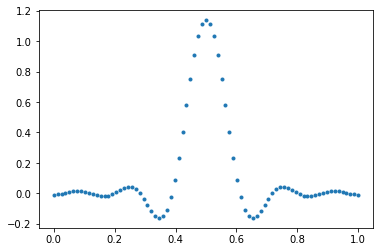

In [6]:
from commpy.filters import rrcosfilter

def generate_filter(symrate, b, sps, span):
    r = rrcosfilter(span * 2 * sps, b, 1.0, 10.0)[1][1:]
    f = np.linspace(0.0, 1.0, len(r))
    plt.plot(f, r, '.')
    return r

rrc_filter = np.array(generate_filter(1.0, 0.5, 10, 4) * 768, dtype=np.int16)
delay = int(len(rrc_filter) / 2)

And now let's take the upsampled symbols and filter them with these
coefficients.

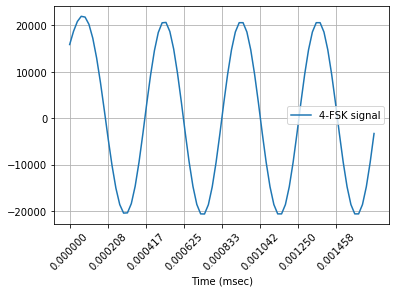

In [7]:
fsk = np.convolve(rrc_filter, upsample(preamble_symbols, 10))

def plot_to_notebook(samples, sample_rate, legend = ['4-FSK signal']):
    
    duration = len(samples) / sample_rate
    t = np.linspace(0, duration, len(samples), endpoint=True)
    plt.figure()
    plt.rcParams['figure.figsize'] = [12, 4]
    ax = plt.subplot(1, 1, 1)
    plt.xlabel('Time (msec)')
    plt.locator_params(axis='y', nbins=8)
    plt.grid()
    plt.xticks(np.arange(0, duration, 1.0/4800.0), rotation=45)
    plt.plot(t, samples, '-')
    plt.legend(legend)

# plot_to_notebook(fsk, 48000)
plot_to_notebook(fsk[delay:delay+80], 48000)

We have now successfully generated the modulated baseband preamble.

This graph shows our baseband transmit signal.  The initial impulse
is a little exaggerated because of the short window.  This is what an
RRC($\alpha=0.5$) looks like when using a filter length of about 4
symbols.  We are targetting an embedded system, so short filters are
the compromise we make.  We will not be flushing this filter while
transmitting a stream.  That impulse is a one-time event.

Note that, save the one-time construction of the RRC filter coefficients,
all computation is integer arithmetic (mostly MAC) and bit shifts.

On the receive side, we need to apply the same RRC filter.

# Link Setup

In this example, we are going to use my call sign WX9O.  Please change
this to your call sign to your own if you begin to experiment with this
code.

The link setup frame looks like this:

 * Destination (48 bits, 6 bytes)
 * Source (48 bits, 6 bytes)
 * Type (16 bits, 2 bytes)
 * Nonce (112 bits, 14 bytes)
 * CRC (16 bits, 2 bytes)
 * Flush (4 bits)
 
The destination in our case is the constant `0xFFFFFFFFFFFF`, which is the
broadcast address.

The source address is `WX9O`, which we need to encode using the base-40
encoder outlined in the specification.  This is the first bit of code we
need to write for the link setup frame.

The type field is going to specify a stream containing voice only, with no
encryption. This is 0x0005.  We will create some constants in the code to
make that clear.

The *nonce* is not used since we are not using encryption.  These we set to
all 0.

We then compute the CRC.

## Callsign Encoding/Decoding

In [8]:
import binascii

def encode_callsign_base40(callsign):
    
    # Encode the characters to base-40 digits.
    encoded = 0;
    for c in callsign[::-1]:
        encoded *= 40;
        if c >= 'A' and c <= 'Z':
            encoded += ord(c) - ord('A') + 1
        elif c >= '0' and c <= '9':
            encoded += ord(c) - ord('0') + 27
        elif c == '-':
            encoded += 37
        elif c == '/':
            encoded += 38
        elif c == '.':
            encoded += 39
        else:
            pass # invalid

    # Convert the integer value to a byte array.
    result = bytearray()
    for i in range(6):
        result.append(encoded & 0xFF)
        encoded >>= 8
        
    return result

callsign = 'WX9O'

encoded_source = encode_callsign_base40(callsign)

print(binascii.hexlify(encoded_source))

b'd78a0f000000'


We need the bytes as a byte array when constructing the Link Setup
frame, so we output it as a byte array. The spec say the byte array
is in little endian format.

Let's verify that we can decode this.

In [9]:
import io
import struct

def decode_callsign_base40(encoded_bytes):
    
    # Convert byte array to integer value.
    i,h = struct.unpack("IH", encoded_bytes)
    encoded = (h << 32) | i
    # print('{:#012x}'.format(encoded))
    
    # Unpack each base-40 digit and map them to the appriate character.
    result = io.StringIO()
    while encoded:
        result.write("xABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-/."[encoded % 40])
        encoded //= 40;
    
    return result.getvalue();

callsign_check = decode_callsign_base40(encoded_source)
print(callsign_check)

WX9O


Let's just briefly explain what we are doing in this code. The code has to treat the byte array as a numeric value in order to easily decode it. We use Python's struct.unpack() function to convert the 6 bytes into a 32-bit and 16-bit number. These two values are then combined into a single value. We then map the value of each base40 digit into the appropriate charater and append them to the result.

Now that we have our source, we will construct the rest of the packet.

## Remainder

We need to add destination, frame type and none.  These are, for this
implementation, fixed values.  The destination is the default. The frame
type is 3200bps audio stream, and the nonce is all 0s.

In [10]:
destination = bytearray([0xff] * 6)
frame_type = bytearray([0x00,0x05])
nonce = bytearray([0x00]*14)

##  CRC

We now need to calculate the CRC.

M17 uses a non-standard 16-bit CRC with a polynomial of 0x5935 and
0xFFFF initial value.  We will implement the code to do that.

The code below is a adapted version of the code available in [PyCRC](https://github.com/tpircher/pycrc/blob/master/pycrc/algorithms.py).

In [11]:
class CRC16(object):
    
    def __init__(self, poly, init):
        self.poly = poly
        self.init = init
        self.mask = 0xFFFF
        self.msb = 0x8000
        self.reset()
    
    def reset(self):
        self.reg = self.init
        for i in range(16):
            bit = self.reg & 0x01
            if bit:
                self.reg ^= self.poly
            self.reg >>= 1
            if bit:
                self.reg |= self.msb
        self.reg &= self.mask

    def crc(self, data):
        for byte in data:
            for i in range(8):
                msb = self.reg & self.msb
                self.reg = ((self.reg << 1) & self.mask) | ((byte >> (7 - i)) & 0x01)
                if msb:
                    self.reg ^= self.poly
         
    def get(self):
        reg = self.reg
        for i in range(16):
            msb = reg & self.msb
            reg = ((reg << 1) & self.mask)
            if msb:
                reg ^= self.poly

        return reg & self.mask
    
         
    def get_bytes(self):
        crc = self.get()
        return bytearray([(crc>>8) & 0xFF, crc & 0xFF])

crc = CRC16(0x5935, 0xFFFF)

Helpfully, the M17 spec has some test cases so we can verify our
results.  Let's validat that the code works as expected.

In [12]:
crc.reset()
crc.crc('')
x = crc.get()
print(hex(x))
assert(x == 0xFFFF)

crc.reset()
crc.crc('A'.encode('ASCII'))
x = crc.get()
print(hex(x))
assert(x == 0x206E)

crc.reset()
crc.crc('123456789'.encode('ASCII'))
x = crc.get()
print(hex(x))
assert(x == 0x772B)

crc.reset()
for i in range(256):
    crc.crc([i])
x = crc.get()
print(hex(x))
assert(x == 0x1C31)

0xffff
0x206e
0x772b
0x1c31


That looks good. So now we need to feed in the source, destination,
frame type, and nonce to compute the CRC.

In [13]:
# Calculate Link Setup CRC
crc.reset()
crc.crc(encoded_source)
crc.crc(destination)
crc.crc(frame_type)
crc.crc(nonce)
block_crc = crc.get_bytes()

print("link setup CRC:", binascii.hexlify(block_crc))

link setup CRC: b'06a6'


If we feed the CRC back into itself, we should get 0.  This means
that, when we receive a frame, we can compute the CRC for the entire
frame including the CRC and expect the result to be 0 for a valid frame.

In [14]:
link_setup_block = np.concatenate([encoded_source, destination, frame_type, nonce, block_crc])
print(binascii.hexlify(link_setup_block))

crc.reset()
crc.crc(link_setup_block)
print(hex(crc.get()))
assert(crc.get() == 0)

b'd78a0f000000ffffffffffff0005000000000000000000000000000006a6'
0x0


## Forward Error Correction

M17 uses a constraint length K=5 rate 1/2 convolutional code FEC.  This
is later punctured for a final rate of 10/17.

We use some of the features of scikit-commpy to do convolutional coding.
The commpy repo contains puncturing code that is not exposed and which
does not work correctly.  I have copied the code here and fixed the
defects in the puncturing and depunctring functions.

https://github.com/veeresht/CommPy/blob/master/commpy/channelcoding/convcode.py

Please note that this code is licensed under the 3-clause BSD license.

The convolutional encoder and decoder work on arrays of bit values.

The convolutional coder handles flushing the coder when "**term**" is passed
as one of the arguments.

In [15]:
from commpy.channelcoding import Trellis, conv_encode, viterbi_decode

def puncturing(message: np.ndarray, punct_vec: np.ndarray) -> np.ndarray:
    """
    Applying of the punctured procedure.
    Parameters
    ----------
    message : 1D ndarray
        Input message {0,1} bit array.
    punct_vec : 1D ndarray
        Puncturing vector {0,1} bit array.
    Returns
    -------
    punctured : 1D ndarray
        Output punctured vector {0,1} bit array.
    """
    shift = 0
    N = len(punct_vec)
    punctured = []
    for idx, item in enumerate(message):
        if punct_vec[idx % N] == 1:
            punctured.append(item)
    return np.array(punctured)

memory = np.array([4])
trellis = Trellis(memory, np.array([[0o31,0o27]]))

def to_bit_array(byte_array):
    return np.concatenate(
        [[int((x & (1<<i)) != 0) for i in range(7,-1,-1)] for x in byte_array])

# Convert bytes to bits
bits = to_bit_array(link_setup_block)
print("LSF =", len(bits), [x for x in bits])

link_setup_block_bits = bits # Saved for later

# Puncture matrix for link setup frame
P1 = [1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1]

print("Len(P1) =", len(P1))

# Encode and puncture
encoded = conv_encode(bits, trellis, "term")
print("encoded =", len(encoded), [x for x in encoded])
punctured = puncturing(encoded, P1)
print("punctured =", len(punctured), [x for x in punctured])

LSF = 240 [1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Len(P1) = 122
encoded = 488 [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Here you can see the bit array for the uncoded link setup frame, followed
by the convolutionally coded and punctured data.

## Interleaving

The next step is to use the polynomial interleaver to interleave the encoded bits.  This scatters the bits across the frame.  The most likely error type is a *burst error* that will damage a few bits in the row. Scattering them with an interleaver results in this burst error affecting uncorrelated bits.  These uncorrelated bit errors are easier to fix via forward error correction.

The interleaving polynomial used is $p(x)=(45x+92x^2)\pmod n$ where $n=368$

The interleaver works by shuffling the date such that

$y[p(x)] = y[x]$

This polynomial comes from here: http://www.ijfcc.org/papers/186-C3015.pdf

The interleaver is code I am re-using from code I wrote experimenting with
OFDM a couple years back.

In [16]:
class PolynomialInterleaver(object):
    """Polynomial bit interleaver.  Default to 80.
    
    Valid LTE polynomials can be found here:
    https://github.com/supermihi/lpdec/blob/master/lpdec/codes/interleaver.py#L264
    """
    
    def __init__(self, f1 = 11, f2 = 20, k = 80):
        
        self.f1 = f1
        self.f2 = f2
        self.K = k
    
    def index(self, i):
        
        return ((self.f1 * i) + (self.f2 * i * i)) % self.K
    
    def interleave(self, data):
        result = np.zeros(self.K, dtype = data.dtype)
        for i in range(len(data)):
            result[self.index(i)] = data[i]
        return result
    
    def deinterleave(self, data):
        
        result = np.zeros(len(data), dtype = data.dtype)
        for i in range(len(data)):
            if i == self.K: break
            result[i] = data[self.index(i)]
        return result

    def interlv(self, data):
        return self.interleave(data)

    def deinterlv(self, data):
        return self.deinterleave(data)

interleaver = PolynomialInterleaver(45, 92, 368)
interleaved = interleaver.interleave(encoded)

print(interleaved)

[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


## Randomization

The final phase of our data manipulation is to randomize the bitstream
(called data whitening or, in the M17 spec,  de-correlation).  This
avoids long blocks of 1s or 0s which can cause an unwanted DC bias and
low frequency content in the baseband signal.

Randomization is done by XORing this interleaved data $x[n]$ with a
psuedo-random sequence $pn[n]$.  This pseudo-random sequence is given in
the M17 spec in the *Decorrelator Sequence* appendix.

$ y[n] = x[n] \otimes pn[n]$

In [17]:
def randomize(frame):
    DC = [0xd6, 0xb5, 0xe2, 0x30, 0x82, 0xFF, 0x84, 0x62,
        0xba, 0x4e, 0x96, 0x90, 0xd8, 0x98, 0xdd, 0x5d,
        0x0c, 0xc8, 0x52, 0x43, 0x91, 0x1d, 0xf8, 0x6e,
        0x68, 0x2F, 0x35, 0xda, 0x14, 0xea, 0xcd, 0x76,
        0x19, 0x8d, 0xd5, 0x80, 0xd1, 0x33, 0x87, 0x13,
        0x57, 0x18, 0x2d, 0x29, 0x78, 0xc3]

    bits = np.concatenate([[int((x & (1<<i)) != 0) for i in range(7,-1,-1)] for x in DC])
    result = np.bitwise_xor(interleaved, bits)
    return result

randomized = randomize(interleaved)
print(randomized)

[1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1
 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1
 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1
 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1
 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 1 1 1
 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0
 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1
 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1
 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1]


## Sync Word

Each frame is prefixed with a 16-bit sync word.  Now is a good time to
pre-pend the frame with the bits from the sync word.  The sync word is
0x3243.

In [18]:
def add_sync_word(frame):
    SW = [0x32, 0x43]
    bits = np.concatenate([[int((x & (1<<i)) != 0) for i in range(7,-1,-1)] for x in SW])
    result = np.concatenate([bits, frame])
    return result

frame = add_sync_word(randomized)
print(frame)

[0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1
 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1
 1 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1
 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0
 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0
 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0
 1 1 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1
 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1
 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 1 1 0
 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1
 1 1 1 0 0 0 1 1 0 0 1 0 1 1]


## Baseband Encoding

Now we need to encoded the data into symbols, and then do baseband encoding
just as was done with the preamble.  We already have the code to convert
bits to symbols.  Here we convert the bitstream to symbols, upsample and
filter the data to baseband, and plot the results.

In [19]:
symbols = np.array([to_4fsk(x*2+y) for x, y in np.split(frame, len(frame) // 2)], dtype=np.int8)
print(symbols)
fsk = np.convolve(rrc_filter, upsample(np.array(symbols), 10))
print(len(symbols), len(fsk))

[ 1 -3  1 -1  3  1  1 -3 -3 -3 -3 -1 -1 -1 -3  3 -3 -1 -1 -1  3 -3 -1  1
 -1  1 -1 -1 -3 -3  3  3 -1  1 -3 -1  3 -1 -1 -1 -1 -3  1 -1  3  1 -3  1
 -1  3  3  1 -1  3 -1 -1 -3  3 -3 -1 -1  3 -1 -1 -3  1 -3 -3  3  1 -1 -3
  1  1 -3 -1 -3  3 -1 -1 -3  3  1  1  3  1  1 -3 -1  3  1  3  1  3 -3 -3
 -3 -3 -1  3 -3 -1 -3 -1 -3 -1 -1  1 -1 -1 -1 -3 -1 -3  1  1  3  3 -3 -1
 -1  3  3  1  3  1 -1 -1  3 -1 -3  3 -3 -3  3 -1 -1  3 -1  3  1  1 -3  3
 -3 -3  3  3 -3 -1  1  1 -3 -3  1  3  1  3  1 -3 -1 -1  3 -1  3 -3  1 -3
  3 -3 -3 -3  1 -3 -1  1  1  1 -3  3  1 -1 -1  3  3 -3 -1  1 -3  1 -1 -3]
192 1998


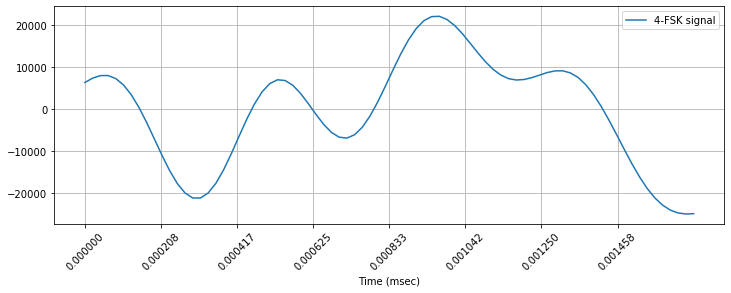

In [20]:
plot_to_notebook(fsk[delay:delay+80], 48000)

## Streaming Audio Data

Now we are on to streaming audio data.  In the following sections we
will be reading audio from a file, using Codec2 to encode the audio
data into a 3200 bit per second (400Bps) stream.  This will be broken
up into 128 bit or 16 byte chunks.  We will be pre-pending a portion
of the link setup frame to each chunk.  The link header and data will
be encoded separately.

## Audio processing

Typical implementations will stream audio data through the Codec2 audio
encoder.  In this case will will read a short audio clip, encode the
entire bitstream and chunk it up.

To prep for this, I needed to run the following:

```
$ sudo dnf install python3-Cython.x86_64 codec2.x86_64
$ pip install --user pycodec2-old
```

Let's read in the raw audio file.  You can also play the audio to see
what the audio input sounds like in its raw form, at 8kbps, 16-bits.

In [21]:
from scipy.io import wavfile
import pycodec2, struct
import IPython.display as ipd

sample_rate, audio = wavfile.read("brain.wav")

ipd.Audio(audio, rate=sample_rate)

And now we will encode the data using Codec2 at 3200bps, and then decode the
data.  Codec2 requires that the data be chunked into samples_per_frame()
samples as it is passed into the encoder.

You can play this processed data to hear what the Codec2 audio stream sounds
like compared to the original.

In [22]:
c2 = pycodec2.Codec2(3200)

# Pad data to an even multiple of Codec2.samples_per_frame()
SPF = c2.samples_per_frame()
padding = SPF - (len(audio) % SPF)
padded_audio = np.concatenate([audio, np.zeros(padding, dtype=np.int16)])

# Encode the audio
encoded_audio = [c2.encode(padded_audio[i:i + SPF]) for i in range(0, len(padded_audio), SPF)]

# Decode the audio back to PCM so it can be played.
decoded_audio = concatenate([c2.decode(x) for x in encoded_audio])

ipd.Audio(decoded_audio, rate=sample_rate)

Now that we have the audio data in encoded form, we need to pack these into
M17 stream frames.  Each stream frame contains 128 bits of data.  We need to
determine the number of bits per frame we received from Codec2.

In [23]:
print("  bits per frame =", c2.bits_per_frame())
print("number of frames =", len(encoded_audio))

  bits per frame = 64
number of frames = 328


This tells us that we need to pack two Codec2 frames into each M17 frame.
The other thing it tells us is that we have an even number of Codec2
frames.  If if were an odd number, the remaining data would get padded
with 0s.

## LICH

The M17 stream frame starts with the *link information channel* (LICH).
The initial 240-bit *Link Setup Frame* (the *superframe*) is split into
6 segments, $SF_0 - SF_5$.  The entire superframe is transmitted
in the LICH every 6 frames.

Each LICH contains 5 bytes (40 bits) of the superframe segment, followed
by one byte which contains a 3-bit LICH frame counter and a 5-bit color
code.  The frame count goes from $0..5$.

*In the examples below we ignore the color code and always set it to 0.*

In [24]:
SF = np.split(to_bit_array(link_setup_block), 6)
for i in range(6):
    SF[i] = np.concatenate([SF[i], to_bit_array([i << 5])])

Here the link setup frame is split into 5 segments.

Each superframe segment is further split into 4 12-bit blocks which
are Golay(12,24,8) encoded.

## Golay(12,24,8)

The extended Golay(12,24,8) is a FEC encoding 12 bits of data which is
able to correct 3 bit errors in a block.  It does this by appending an
12-bit parity code to the data.  This doubles the amount of data being
sent.  Decoding is fast, at the expense of some memory.  (It takes a minimum
of about 12KB, which is actually quite a lot for small embedded systems.)

Since there is no ready Python library for Golay(12, 24, 8) implement
this here using the following references:

 * https://en.wikipedia.org/wiki/Binary_Golay_code
 * https://www.maplesoft.com/applications/view.aspx?SID=1757&view=html
 * https://github.com/biocore/qiime/blob/master/qiime/golay.py
 * https://www.johndcook.com/blog/2019/10/18/golay-code/
 * http://aqdi.com/articles/using-the-golay-error-detection-and-correction-code-3/

Note that the cited Python implementation uses a different parity matrix from the one we use here.

In [25]:
class Golay24(object):
    
    POLY = 0xC75
    POLY_a = np.array([1,1,0,0,0,1,1,1,0,1,0,1], dtype=np.int)
    
    @staticmethod
    def syndrome(codeword):
        
        for i in range(12):
            if codeword & 1:
                codeword ^= Golay24.POLY
            codeword >>= 1
            
        return codeword

    @staticmethod
    def popcount(data):
        count = 0
        for i in range(24):
            count += (data & 1)
            data >>= 1
        return count
    
    @staticmethod
    def parity(data):
        return Golay24.popcount(data) & 1
    
    def __init__(self):
                
        # Construct the syndrome-keyed correction lookup table.
        self.LUT = {}
        for error in self._make_3bit_errors(23):
            syn = self.syndrome(error)
            self.LUT[syn] = error

    def encode23(self, bits):
        codeword = bits;
        for i in range(12):
            if codeword & 1:
                codeword ^= Golay24.POLY
            codeword >>= 1
        return codeword | (bits << 11)


    def encode(self, bits):

        codeword = self.encode23(bits)
        return (codeword << 1) | self.parity(codeword)

    def encode_array(self, bits):
        
        data = 0
        for bit in bits:
            data = (data << 1) | bit
        codeword = self.encode23(data)
        encoded = (codeword << 1) | self.parity(codeword)
        result = np.zeros(24, dtype=int)
        for i in range(24):
            result[23 - i] = encoded & 1
            encoded >>= 1
        
        return result
    
    def decode(self, bits):
        syndrm = self.syndrome(bits >> 1);
        try:
            correction = self.LUT[syndrm]
            errors = self.popcount(correction)
            corrected = bits ^ (correction << 1)
            if (errors < 3) or not parity(corrected):
                return corrected, errors
            else:
                return None, 4
        except KeyError:
            return None, 4

    def decode_array(self, bits):
        
        data = 0
        for bit in bits:
            data = (data << 1) | bit
        decoded, errors = self.decode(data)
        if decoded is None:
            return decoded, errors
        
        result = np.zeros(24, dtype=int)
        for i in range(24):
            result[23 - i] = decoded & 1
            decoded >>= 1
        
        return result, errors

    @staticmethod
    def _make_3bit_errors(veclen=24):
        """Return a list of all bitvectors with <= 3 bits as 1's.
        This returns list of lists, each 24 bits long by default.
        """
        errorvecs = []
        # all zeros
        errorvecs.append(0)
        # one 1
        for i in range(veclen):
            errorvecs.append(1 << i)

        # two 1s
        for i in range(veclen - 1):
            for j in range(i + 1, veclen):
                errorvecs.append((1 << i) | (1 << j))

        # three 1s
        for i in range(veclen  - 2):
            for j in range(i + 1, veclen - 1):
                for k in range(j + 1, veclen):
                    errorvecs.append((1 << i) | (1 << j) | (1 << k))
        return errorvecs

golay = Golay24()
# print([[x for x in y] for y in golay.G])
# print([[x for x in y] for y in golay.H])
print(SF[0])
encoded_block = golay.encode_array(SF[0][:12])
print("    Link setup group =", SF[0][:12])
print("          LICH group =", encoded_block)

# Apply a 2-bit error to the data.
error = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
received = np.bitwise_xor(encoded_block, error)

print("Corrupted LICH group =", received)

# Decode the corrupted stream
decoded, errors = golay.decode_array(received)
print("Corrected link setup =", decoded)
print("          Bit errors =", errors)

[1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
    Link setup group = [1 1 0 1 0 1 1 1 1 0 0 0]
          LICH group = [1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1]
Corrupted LICH group = [1 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1]
Corrected link setup = [1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1]
          Bit errors = 2


Now we can encode each group of the superframe.

In [26]:
EF = []
for i, segment in enumerate(SF):
    print("SF[%d] =" % i, segment)
    EF.append(np.concatenate([golay.encode_array(x) for x in np.split(segment, 4)]))
    print("EF[%d] =" %i, EF[i], len(EF[i]))

SF[0] = [1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
EF[0] = [1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0
 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 96
SF[1] = [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 1 0 0 0 0 0]
EF[1] = [0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1] 96
SF[2] = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0]
EF[2] = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1] 96
SF[3] = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

## Frame Number

Each data frame has a frame number (FN), which starts at 0 an monotinically
increases to 0x7FFF (32767) at which point it rolls to 0 again.  The high
bit of the frame number is set to indicate the last frame in the stream.
We will need to be able to turn this 16-bit value into a 2-byte byte array.

In [27]:
FN = 0

def to_byte_array(f):
    return bytearray([(f>>8) & 0xFF, f & 0xFF])

fn = to_byte_array(FN)

## Stream CRC

The next step in the process is to calculate the CRC.  The CRC is calculated
using the 16 bits of the frame number, and 128 bits of audio data.

We will use the same CRC object constructed earlier for the link setup frame.

Recall that we need 2 Codec2 frames for each M17 frame.

In [28]:
crc.reset()
crc.crc(fn)
crc.crc(encoded_audio[0])
crc.crc(encoded_audio[1])
block_crc = crc.get_bytes()
print("CRC =", binascii.hexlify(block_crc))

CRC = b'5c72'


## Convolutional Coding

We now need to apply forward error correction to the FN, audio data and CRC.
This is 16 bits of FN, 128 bits of audio data, and 16 bits of CRC.

The M17 spec says that we need 4 bits to flush the encoder, but our encoder
does this for us.

This is convolutionally coded to 328 bits and then punctured down to 272 bits.
The puncture matrix (P2) for the data frames is different from that of the link
setup frame (P1).

In [29]:
P2 = np.array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

print("len(P2) =", len(P2))

frame_data = fn + encoded_audio[0] + encoded_audio[1] + block_crc
print("Frame data:", binascii.hexlify(frame_data))
bits = to_bit_array(frame_data)
print("Frame bits:")
print(bits, len(bits))

frame_fec = puncturing(conv_encode(bits, trellis, 'term'), P2)

print("  FEC bits:")
print([x for x in frame_fec], len(frame_fec))

len(P2) = 82
Frame data: b'0000c030aa3a18a5ef0bc02cd86b9ea5a76e5c72'
Frame bits:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1
 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0
 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1
 1 1 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 0 0 1 0 1
 1 1 0 0 0 1 1 1 0 0 1 0] 160
  FEC bits:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 

## Interleaving

We now need to concatenate the LICH with the FEC bits and interleave the
bits as we did with the link setup frame.

In [30]:
data_frame = np.concatenate([EF[0], frame_fec])
interleaved_data = interleaver.interleave(data_frame)
print("Interleaved:")
print(interleaved_data)

Interleaved:
[1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1
 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0
 0 1 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 0 1 0
 1 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0
 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0
 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0
 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1
 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 1]


## Randomization

Just as with the link setup frame, the data frame must be randomized.

In [31]:
randomized_data = randomize(interleaved_data)
print("Randomized:")
print(randomized_data, len(randomized_data))

Randomized:
[1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1
 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1
 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1
 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1
 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 1 1 1
 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0
 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1
 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1
 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1] 368


## Sync Word

And lastly we need to prepend the sync word to the randomized frame.

In [32]:
final_frame = add_sync_word(randomized_data)
print("Final:")
print(final_frame, len(final_frame))

Final:
[0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1
 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1
 1 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1
 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0
 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0
 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0
 1 1 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1
 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1
 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 1 1 0
 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1
 1 1 1 0 0 0 1 1 0 0 1 0 1 1] 384


# Complete Modulator

The remaining steps for baseband modulation remain the same as with the
link setup frame.  The bitstream is upsampled and convolved with the
RRC filter taps.

It is now time to turn our attention to putting this all together into
a single modulator.

We are going to create a class that creates a link setup frame based
on the parameters passed during construction, and then output the LSF
and audio data as baseband modulation.

The modulator has no support for scrambling or encryption.

This uses the CRC16, PolynomialInterleaver and Golay24 classes defined
earlier.  It pulls the remainder of what was done to build the preamble,
link setup frame and audio frames into a single class.

In [39]:
from scipy.signal import lfiltic, lfilter
from commpy.filters import rrcosfilter

class M17Modulator(object):
    
    @staticmethod
    def puncturing(message: np.ndarray, punct_vec: np.ndarray) -> np.ndarray:
        """
        Applying of the punctured procedure.
        Parameters
        ----------
        message : 1D ndarray
            Input message {0,1} bit array.
        punct_vec : 1D ndarray
            Puncturing vector {0,1} bit array.
        Returns
        -------
        punctured : 1D ndarray
            Output punctured vector {0,1} bit array.
        """
        shift = 0
        N = len(punct_vec)
        punctured = []
        for idx, item in enumerate(message):
            if punct_vec[idx % N] == 1:
                punctured.append(item)
        return np.array(punctured)

    @staticmethod
    def encode_callsign_base40(callsign):
    
        # Encode the characters to base-40 digits.
        encoded = 0;
        for c in callsign[::-1]:
            encoded *= 40;
            if c >= 'A' and c <= 'Z':
                encoded += ord(c) - ord('A') + 1
            elif c >= '0' and c <= '9':
                encoded += ord(c) - ord('0') + 27
            elif c == '-':
                encoded += 37
            elif c == '/':
                encoded += 38
            elif c == '.':
                encoded += 39
            else:
                pass # invalid

        # Convert the integer value to a byte array.
        result = bytearray()
        for i in range(6):
            result.append(encoded & 0xFF)
            encoded >>= 8

        return result

    @staticmethod
    def decode_callsign_base40(encoded_bytes):
    
        # Convert byte array to integer value.
        i,h = struct.unpack("IH", encoded_bytes)
        encoded = (h << 32) | i
        print('{:#012x}'.format(encoded))

        # Unpack each base-40 digit and map them to the appriate character.
        result = io.StringIO()
        while encoded:
            result.write("xABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-/."[encoded % 40])
            encoded //= 40;

        return result.getvalue();
    
    @staticmethod
    def to_4fsk(symbol):
        """Convert a pair of bits to a 4-FSK symbol."""
        if symbol == 0: return 1
        elif symbol == 1: return 3
        elif symbol == 2: return -1
        elif symbol == 3: return -3
        else: raise ValueError("not a value 4-FSK symbol")

    @staticmethod
    def binary_to_symbols(bits):
        """Return an array of binary symbols (bit pairs) to 4-FSK symbols."""
        return np.array([to_4fsk(x) for x in bits], dtype=np.int8)

    @staticmethod
    def byte_to_symbols(data):
        """Convert byte to big endian symbol stream."""
        result = np.zeros(4, dtype=np.uint8)
        for i in range(4):
            result[i] = (data & 0xC0) >> 6
            data = data << 2
        return result

    @staticmethod
    def bytes_to_symbols(data):
        binary_symbols = np.concatenate(np.array([byte_to_symbols(x) for x in data]))
        return binary_to_symbols(binary_symbols)
    
    @staticmethod
    def to_bit_array(byte_array):
        """Convert byte array to big-endian bit array."""
        return np.concatenate(
            [[int((x & (1<<i)) != 0) for i in range(7,-1,-1)] for x in byte_array])
    
    @staticmethod
    def to_byte_array(f):
        """Convert a 16-bit integer into a two-byte array."""
        return bytearray([(f>>8) & 0xFF, f & 0xFF])


    # Puncture matrix for link setup frame.
    P1 = [1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
            1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
            1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
            0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
            0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
            1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1]

    # Puncture matrix for data frames.
    P2 = [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
            0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
            0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
    
    # Randomization matrix.
    DC = [0xd6, 0xb5, 0xe2, 0x30, 0x82, 0xFF, 0x84, 0x62,
        0xba, 0x4e, 0x96, 0x90, 0xd8, 0x98, 0xdd, 0x5d,
        0x0c, 0xc8, 0x52, 0x43, 0x91, 0x1d, 0xf8, 0x6e,
        0x68, 0x2F, 0x35, 0xda, 0x14, 0xea, 0xcd, 0x76,
        0x19, 0x8d, 0xd5, 0x80, 0xd1, 0x33, 0x87, 0x13,
        0x57, 0x18, 0x2d, 0x29, 0x78, 0xc3]

    # Sync word.
    SW = [0x32, 0x43]

    def __init__(self, mycall, rate = 48000):
        self.mycall = mycall
        self.MYCALL = self.encode_callsign_base40(mycall)
        self.frame_type = bytearray([0x00,0x05])
        self.nonce = bytearray([0x00]*14)
        
        self.symbol_rate = 4800.0
        self.samples_per_second = rate
        self.samples_per_symbol = int(self.samples_per_second / self.symbol_rate);
        self.taps = int(self.samples_per_symbol * 8 + 1)
        self.delay = int((self.taps) // 2)
        self.rrc_filter = rrcosfilter(self.taps, 0.5, 1.0/self.symbol_rate, self.samples_per_second)[1][1:]
        self.zl = lfiltic(self.rrc_filter, 1.33, [], [])
        self.crc = CRC16(0x5935, 0xFFFF)
        self.memory = np.array([4])
        self.trellis = Trellis(self.memory, np.array([[0o31,0o27]]))
        self.interleaver = PolynomialInterleaver(45, 92, 368)
        self.dc = self.to_bit_array(self.DC)
        self.sw = self.to_bit_array(self.SW)
        self.golay = Golay24()

    def transmit(self, audio, tocall = None):
        
        self.tocall = tocall
        self.TOCALL = bytearray([0xff] * 6) if tocall is None else encode_callsign_base40(tocall)
        self.frame_number = 0

        yield self.generate_preamble()
        yield self.generate_link_setup()
        
        c2 = pycodec2.Codec2(3200)
        for i in range(0, len(audio), c2.samples_per_frame() * 2):
            start = i
            end = start + c2.samples_per_frame()
            chunk = audio[start:end]
            if len(chunk) != c2.samples_per_frame():
                chunk = np.concatenate([chunk, np.zeros(c2.samples_per_frame() - len(chunk), dtype=chunk.dtype)])
            encoded = c2.encode(chunk)
            start += c2.samples_per_frame()
            end += c2.samples_per_frame()
            chunk = audio[start:end]
            if len(chunk) != c2.samples_per_frame():
                chunk = np.concatenate([chunk, np.zeros(c2.samples_per_frame() - len(chunk), dtype=chunk.dtype)])
            encoded += c2.encode(chunk)
            yield self.generate_audio_frame(encoded)
        
        yield self.generate_audio_frame()
        yield self.generate_end()
    
    def upsample(self, input):
        """Upsample (interpolate) the input by the 'n'.  This does
        nothing more that duplicate each symbol n times.  It can
        also provide a gain factor."""

        return np.concatenate([[x] + [0] * (self.samples_per_symbol - 1) for x in input])

    def filter(self, symbols):
        result, self.zl = lfilter(self.rrc_filter, 1.33, self.upsample(symbols), -1, self.zl)
        return result
    
    def generate_preamble(self):
        """Generate the baseband signal for the preamble."""
        
        preamble_bytes = np.array([0x77]*48, dtype=np.uint8)
        preamble_symbols = bytes_to_symbols(preamble_bytes)
        return to_bit_array(preamble_bytes), self.filter(preamble_symbols)
    
    def generate_end(self):
        """Generate nothing for the last frame."""
        
        end_bytes = np.array([0x00]*48, dtype=np.uint8)
        end_symbols = bytes_to_symbols(end_bytes)
        return to_bit_array(end_bytes), self.filter(end_symbols)

    def generate_link_setup(self):
        """Generate the baseband signal for the link setup frame."""
        
        self.crc.reset()
        self.crc.crc(self.MYCALL)
        self.crc.crc(self.TOCALL)
        self.crc.crc(self.frame_type)
        self.crc.crc(self.nonce)
        block_crc = self.crc.get_bytes()
        link_setup_block = np.concatenate([self.MYCALL, self.TOCALL, self.frame_type, self.nonce, block_crc])
        link_setup_bits = self.to_bit_array(link_setup_block)
        self.SF = np.split(link_setup_block, 6)
        for i in range(6):
            self.SF[i] = np.concatenate([self.SF[i], ([i << 5])])
        self.sf_index = 0
        # Encode and puncture
        encoded = self.puncturing(conv_encode(link_setup_bits, self.trellis, 'term'), self.P1)
        interleaved = self.interleaver.interleave(encoded)
        randomized = np.bitwise_xor(interleaved, self.dc)
        complete_frame = np.concatenate([self.sw, randomized])
        symbols = [self.to_4fsk(x*2+y) for x, y in np.split(complete_frame, len(complete_frame) // 2)]
        # print(symbols)
        return complete_frame, self.filter(symbols)

    def generate_audio_frame(self, audio = None):
        """Generate the baseband signal for the data frame."""
        
        LICH = self.SF[self.sf_index]
        self.sf_index += 1
        if self.sf_index == len(self.SF):
            self.sf_index = 0
        lich = self.to_bit_array(LICH)
        encoded_lich = np.concatenate([self.golay.encode_array(x) for x in np.split(lich, 4)])
        fn = self.to_byte_array(self.frame_number | 0x8000 if audio is None else 0)
        self.frame_number += 1
        if self.frame_number == 0x8000:
            self.frame_number = 0
        self.crc.reset()
        self.crc.crc(fn)
        data = audio if audio is not None else bytearray([0] * 128)
        self.crc.crc(data)
        block_crc = self.crc.get_bytes()
        
        frame_block = fn + data + block_crc
        frame_bits = to_bit_array(frame_block)
        frame_fec = self.puncturing(conv_encode(frame_bits, self.trellis, 'term'), self.P2)
        frame_full = np.concatenate([encoded_lich, frame_fec])
        interleaved = self.interleaver.interleave(frame_full)
        randomized = np.bitwise_xor(interleaved, self.dc)
        complete_frame = np.concatenate([self.sw, randomized])
        symbols = [self.to_4fsk(x*2+y) for x, y in np.split(complete_frame, len(complete_frame) // 2)]
        return complete_frame, self.filter(symbols)
        
# Write out baseband modulation as "m17-4fsk.wav".
modulator = M17Modulator("WX9O")
sample_rate, audio = wavfile.read("brain.wav")
baseband_data = np.concatenate([baseband for bits, baseband in modulator.transmit(audio)])
# Convert to 16-bit integer
audio_output = np.array(baseband_data * 1000, np.int16)
wavfile.write("m17-4fsk.wav", 48000, audio_output)

# Write out the encoded bitstream as "m17.bin"
modulator = M17Modulator("WX9O")
modulator_bits = np.concatenate([bits for bits, baseband in modulator.transmit(audio)])
def to_byte(bits):
    x = byte(0)
    for bit in bits:
        x <<= 1
        x |= bit
    return x
modulator_bytes = bytearray([to_byte(bits) for bits in np.split(modulator_bits, len(modulator_bits) // 8)])
open("m17.bin", "wb").write(modulator_bytes)

8064

The above code has encoded and modulated the audio file. It has
produced two output files: the `m17-4fsk.wav` file containing
the baseband modulation, and `m17.bin` containing the encoded
bits.  `m17.bin` can be used as a reference to calculate the
bit error rate (BER) of the demodulated data.

# Animation

As one final step, we will animate the baseband waveform.

<Figure size 864x288 with 0 Axes>

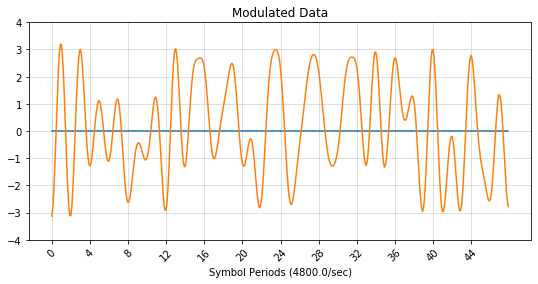

In [34]:
from matplotlib import animation, rc
from IPython.display import HTML

class Animation(object):
    
    def __init__(self):

        self.sample_rate = 48000.0
        self.modulator = M17Modulator("WX9O", self.sample_rate)
        x, self.audio = wavfile.read("brain.wav")
        self.generator = self.modulator.transmit(self.audio)
        self.symbol_rate = 4800.0
        self.samples_per_symbol = int(self.sample_rate / self.symbol_rate)
        self.symbols = 48.0
        self.duration = self.symbols / self.symbol_rate # 48 symbols, 1/4 of a frame
        self.samples_per_frame = int(self.symbols * self.samples_per_symbol)
        self.t = np.linspace(0, self.duration, self.samples_per_frame, endpoint=False)
        plt.figure()
        plt.rcParams['figure.figsize'] = [9, 4]

        self.fig, self.ax = plt.subplots(1, sharex=True)
        plt.xlabel('Symbol Periods ({}/sec)'.format(self.symbol_rate))
        plt.title("Modulated Data")
        plt.rcParams["animation.html"] = "jshtml"
        plt.rcParams["animation.embed_limit"] = 20.0
        self.ax.grid(which='major', alpha=0.5)
        plt.xticks(np.arange(0, self.duration, self.duration / self.symbols), rotation=45)
        self.ax.set_xticklabels(np.arange(0, int(self.symbols), 4))
        self.ax.set_ylim(-4, 4)

        plt.locator_params(axis='y', nbins=9)
        plt.locator_params(axis='x', nbins=self.symbols / 4)

    def init(self):
        self.fsk = np.zeros(self.samples_per_frame)
        self.fsk_line, = self.ax.plot(self.t, self.fsk, '-', label='4-FSK signal')
        self.fsk_line.set_data(self.t, self.fsk)
        return (self.fsk_line,)

    def animate(self, i):
        
        if (i % 4) == 0:
            self.fsk = next(self.generator)[1]
            self.start = 0
        
        self.end = self.start + self.samples_per_frame
        self.fsk_line.set_data(self.t, self.fsk[self.start:self.end])
        self.start += self.samples_per_frame
        return (self.fsk_line,)

a = Animation()
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(
    a.fig, a.animate, init_func=a.init,
    frames=100, interval=1000/24, blit=True)

HTML(anim.to_jshtml())

# metadata = dict(title='M17', artist='Mobilinkd LLC', comment='audio stream')
# anim.save('animation.webm', writer='ffmpeg', fps=60, metadata=metadata, codec='libvpx-vp9')